# CNN training

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

plt.style.use('seaborn')

2022-03-26 21:45:09.351520: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-26 21:45:09.351539: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Loading the images

In [2]:
batch_size = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS = 3

In [3]:
print('Loading images for normal training:\n')

idg_train = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                            rescale=1. / 255,
                                                            zoom_range=0.2)
idg_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                           validation_split=0.5)

# Since we have already split the data between train and test (0.8 and 0.2)
# We obtain here the split train/val/test : 0.8 / 0.1 / 0.1

train_set = idg_train.flow_from_directory('data/train',
                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                    batch_size=batch_size)
val_set = idg_test.flow_from_directory('data/test',
                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                  batch_size=batch_size,
                                  subset='training')
test_set = idg_test.flow_from_directory('data/test',
                                        target_size=(IMG_WIDTH, IMG_HEIGHT),
                                        batch_size=batch_size,
                                        subset='validation')

print('-------------------------------------\n')
print('Loading images for One Shot learning:\n')

idg_os_train = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                               rescale=1. / 255,
                                                               zoom_range=0.2)
idg_os_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255,
                                                              validation_split=0.5)
train_set_os = idg_os_train.flow_from_directory('data/train_os',
                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                             batch_size=batch_size)
val_set_os = idg_os_test.flow_from_directory('data/test_os',
                                          target_size=(IMG_WIDTH, IMG_HEIGHT),
                                          batch_size=batch_size,
                                          subset='training')
test_set_os = idg_os_test.flow_from_directory('data/test_os',
                                           target_size=(IMG_WIDTH, IMG_HEIGHT),
                                           batch_size=batch_size,
                                           subset='validation')

Loading images for normal training:

Found 1521 images belonging to 15 classes.
Found 193 images belonging to 15 classes.
Found 189 images belonging to 15 classes.
-------------------------------------

Loading images for One Shot learning:

Found 5 images belonging to 5 classes.
Found 250 images belonging to 5 classes.
Found 247 images belonging to 5 classes.


In [4]:
class_to_int = train_set.class_indices
int_to_class = {val: key for key, val in class_to_int.items()}

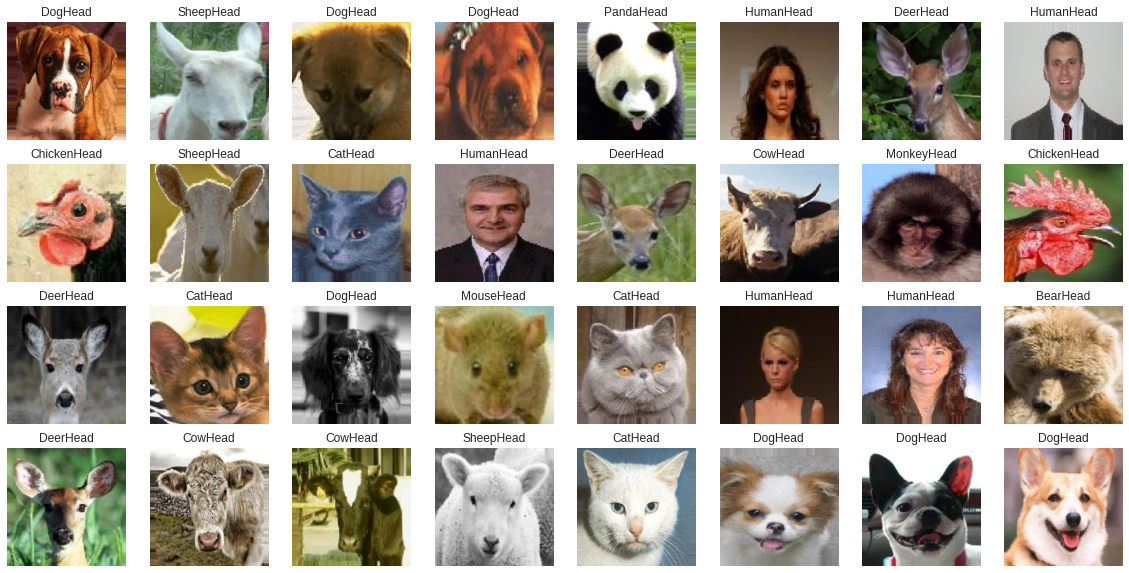

In [5]:
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.ravel()

images, labels = train_set[0]
for i in range(len(images)):
    label_index = np.argmax(labels[i])
    image, label = images[i], int_to_class[label_index]
    axes[i].imshow((255 * image).astype("uint8"))
    axes[i].set_title(label)
    axes[i].axis('off')

In [6]:
class_to_int_os = train_set_os.class_indices
int_to_class_os = {val: key for key, val in class_to_int_os.items()}

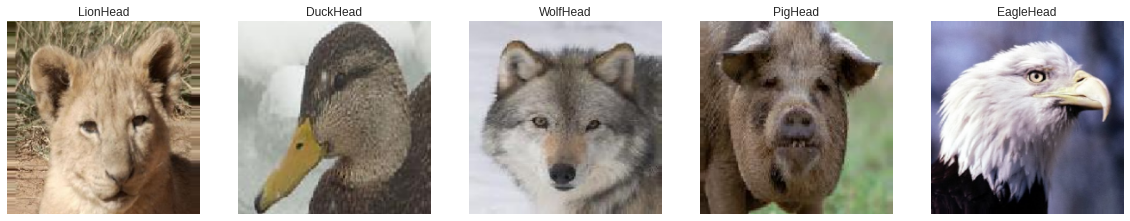

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(20, 10))
axes = axes.ravel()

images, labels = train_set_os[0]
for i in range(len(images)):
    label_index = np.argmax(labels[i])
    image, label = images[i], int_to_class_os[label_index]
    axes[i].imshow((255 * image).astype("uint8"))
    axes[i].set_title(label)
    axes[i].axis('off')

## Defining a CNN

In [8]:
import tensorflow.keras.layers as layers

In [9]:
class Conv2D_Block(layers.Layer):
    def __init__(self, filters, kernel_size, pool_size, suffix=''):
        super(Conv2D_Block, self).__init__()
        self.conv2D = layers.Conv2D(filters, kernel_size, activation='relu',
                                    name='Conv2D_' + suffix)
        self.max_pool = layers.MaxPooling2D(pool_size, strides=(2, 2), name='MaxPooling_' + suffix)
        self.batch_norm = layers.BatchNormalization(name='BatchNorm_' + suffix)
        
    def __str__(self):
        return '\n'.join([str(self.conv2D),
                          str(self.max_pool),
                          str(self.batch_norm)
                         ])    
    def call(self, input_tensor, training=False):
        x = self.conv2D(input_tensor)
        x = self.max_pool(x)
        x = self.batch_norm(x, training=training)
        x = tf.nn.relu(x)
        x = layers.Dropout(0.2)(x)
        return x

In [10]:
class CNN(tf.keras.Model):
    def __init__(self, n_blocks, filters, kernel_sizes, n_classes, name=''):
        assert n_blocks == len(filters), 'n_blocks must be equal to filters\' length'
        assert n_blocks == len(kernel_sizes), 'n_blocks must be equal to kernel_sizes\' length'
        self.n_blocks = n_blocks
        super(CNN, self).__init__(name=name)
        self.n_classes = n_classes
        self.conv_blocks = []
        self.dropout = []
        for i in range(n_blocks):
            self.conv_blocks.append(Conv2D_Block(filters[i],
                                                 kernel_sizes[i],
                                                 pool_size=(2, 2),
                                                 suffix=str(i)))
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(500, activation='relu')
        self.out = layers.Dense(n_classes, activation='softmax')
    
    def call(self, input_tensor, training=False):
        x = input_tensor
        for i in range(self.n_blocks):
            x = self.conv_blocks[i](x, training=training)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.out(x)
        return x

## Defining plot function for training

In [33]:
def plot_training_history(history, callback=None, savefig=False, name='plot.png'):
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes = axes.ravel()
    x = range(1, len(history['loss']) + 1)
    axes[0].plot(x, history['loss'], label='train set')
    axes[0].plot(x, history['val_loss'], label='validation set')
    axes[0].set_xlim(x[0], x[-1])
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss evolution over epochs')
    axes[0].legend()
    
    if callback is not None:   
        if len(history['categorical_accuracy']) < nb_epochs or \
           history['val_categorical_accuracy'][nb_epochs - 1 - callback.patience] < \
           history['val_categorical_accuracy'][-1]:
            x_annot = len(x) - callback.patience
        else:
            x_annot = len(x)
    
    else: 
        x_annot = np.argmax(history['val_categorical_accuracy'])
        y_annot = history['val_categorical_accuracy'][x_annot]

    y_annot = history['val_categorical_accuracy'][x_annot - 1] + 0.01

    axes[1].plot(x, history['categorical_accuracy'], label='train set')
    axes[1].plot(x, history['val_categorical_accuracy'], label='validation set')
    axes[1].set_xlim(x[0], x[-1])
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Categorical accuracy')
    axes[1].set_title('Categorical accuracy evolution over epochs')
    axes[1].annotate('Best model', xy=(x_annot, y_annot), xytext = (x_annot, y_annot * 1.2),
                     arrowprops={'facecolor': 'black', 'shrink': 0.01, 'width': 0.5},
                     horizontalalignment='center', verticalalignment='top')
    plt.legend()
    plt.show()
    if savefig:
        if not os.path.exists('CNN_outputs'):
            os.makedirs('CNN_outputs')
        plt.savefig('CNN_outputs/' + name)

## Training

### 3 blocks CNN with Dropout

In [12]:
n_classes = len(int_to_class)
n_blocks = 3
filters = [32] * n_blocks
kernel_sizes = [(3, 3)] * n_blocks
name = 'CNN_' + str(n_blocks) + 'blocks'
model = CNN(n_blocks, filters, kernel_sizes, n_classes, name)

2022-03-26 21:45:12.242798: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-26 21:45:12.242859: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vincent-Yoga): /proc/driver/nvidia/version does not exist
2022-03-26 21:45:12.243734: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=10,
                                            restore_best_weights=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

In [14]:
nb_epochs = 100
model.fit(x=train_set, validation_data=val_set, epochs=nb_epochs, callbacks=[callback], verbose=1)

Epoch 1/100
48/48 [==============================] - 32s 648ms/step - loss: 4.8488 - categorical_accuracy: 0.2689 - val_loss: 2.6927 - val_categorical_accuracy: 0.1503
Epoch 2/100
48/48 [==============================] - 32s 676ms/step - loss: 1.7718 - categorical_accuracy: 0.5030 - val_loss: 2.7026 - val_categorical_accuracy: 0.0777
Epoch 3/100
48/48 [==============================] - 32s 669ms/step - loss: 1.2644 - categorical_accuracy: 0.6180 - val_loss: 2.6992 - val_categorical_accuracy: 0.0570
Epoch 4/100
48/48 [==============================] - 33s 674ms/step - loss: 0.9474 - categorical_accuracy: 0.7094 - val_loss: 2.6536 - val_categorical_accuracy: 0.1399
Epoch 5/100
48/48 [==============================] - 33s 682ms/step - loss: 0.7294 - categorical_accuracy: 0.7692 - val_loss: 2.5228 - val_categorical_accuracy: 0.1969
Epoch 6/100
48/48 [==============================] - 34s 707ms/step - loss: 0.6077 - categorical_accuracy: 0.8041 - val_loss: 2.3224 - val_categorical_accuracy:

In [15]:
model.summary()

Model: "CNN_3blocks"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d__block (Conv2D_Block  multiple                 1024      
 )                                                               
                                                                 
 conv2d__block_1 (Conv2D_Blo  multiple                 9376      
 ck)                                                             
                                                                 
 conv2d__block_2 (Conv2D_Blo  multiple                 9376      
 ck)                                                             
                                                                 
 flatten (Flatten)           multiple                  0         
                                                                 
 dense (Dense)               multiple                  10816500  
                                                       

In [16]:
history = model.history.history

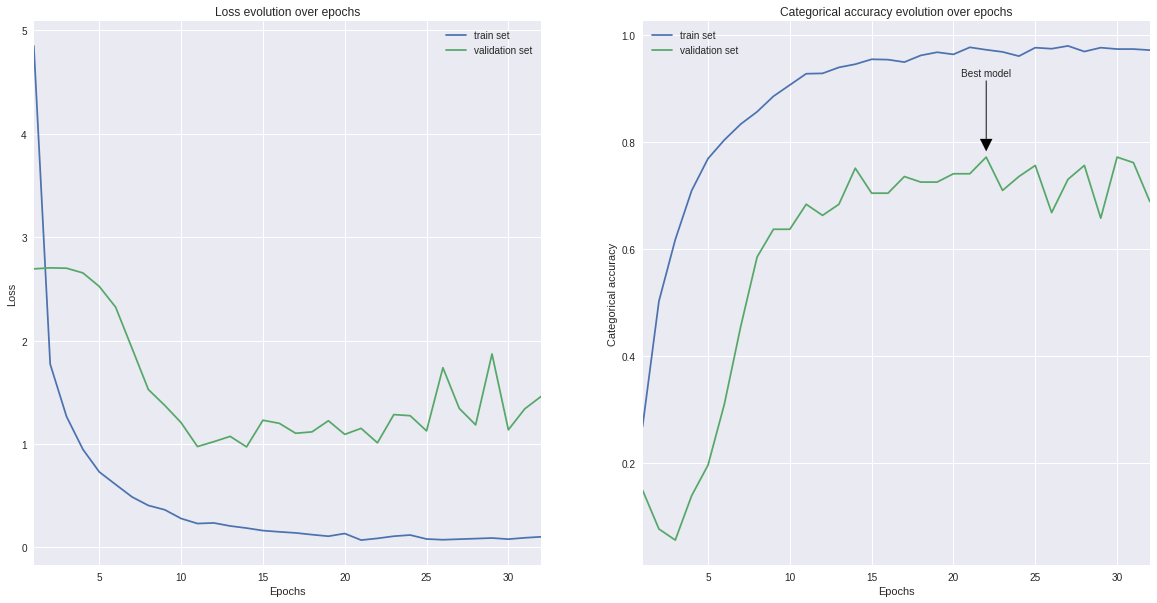

<Figure size 576x396 with 0 Axes>

In [17]:
name = 'Training history plot.png'
plot_training_history(history, callback, savefig=True, name=name)

In [18]:
cat_acc_test = model.evaluate(test_set)[1]

6/6 [==============================] - 1s 123ms/step - loss: 0.9170 - categorical_accuracy: 0.7725


In [19]:
model.save('CNN_outputs/CNN.hd5')

2022-03-26 22:03:36.109567: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: CNN_outputs/CNN.hd5/assets


INFO:tensorflow:Assets written to: CNN_outputs/CNN.hd5/assets


## Replacing the last layer for One Shot Learning

In [28]:
from copy  import copy

In [29]:
n_classes_os = len(int_to_class_os)

model_os = tf.keras.Sequential()
model_os.add(layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
for layer in model.layers[:-1]:
    model_os.add(copy(layer))
model_os.add(layers.Dense(n_classes_os, activation='softmax'))
model_os.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model_os.summary()
callback_os = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=20,
                                            restore_best_weights=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d__block (Conv2D_Block  (None, 111, 111, 32)     1024      
 )                                                               
                                                                 
 conv2d__block_1 (Conv2D_Blo  (None, 54, 54, 32)       9376      
 ck)                                                             
                                                                 
 conv2d__block_2 (Conv2D_Blo  (None, 26, 26, 32)       9376      
 ck)                                                             
                                                                 
 flatten (Flatten)           (None, 21632)             0         
                                                                 
 dense (Dense)               (None, 500)               10816500  
                                                      

In [30]:
nb_epochs = 1000
model_os.fit(x=train_set_os, validation_data=val_set_os, epochs=nb_epochs, callbacks=[callback], verbose=1)

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 3.6748 - categorical_accuracy: 0.2000 - val_loss: 3.0589 - val_categorical_accuracy: 0.2480
Epoch 2/1000
1/1 [==============================] - 1s 1s/step - loss: 1.1360 - categorical_accuracy: 0.4000 - val_loss: 2.6757 - val_categorical_accuracy: 0.3160
Epoch 3/1000
1/1 [==============================] - 1s 1s/step - loss: 0.4305 - categorical_accuracy: 0.8000 - val_loss: 2.5562 - val_categorical_accuracy: 0.3440
Epoch 4/1000
1/1 [==============================] - 1s 1s/step - loss: 0.1351 - categorical_accuracy: 1.0000 - val_loss: 2.5691 - val_categorical_accuracy: 0.3800
Epoch 5/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0247 - categorical_accuracy: 1.0000 - val_loss: 2.6989 - val_categorical_accuracy: 0.4120
Epoch 6/1000
1/1 [==============================] - 1s 1s/step - loss: 0.0133 - categorical_accuracy: 1.0000 - val_loss: 2.9454 - val_categorical_accuracy: 0.4080
Epoch 7/1000
1/1 [====

In [31]:
history_os = model_os.history.history

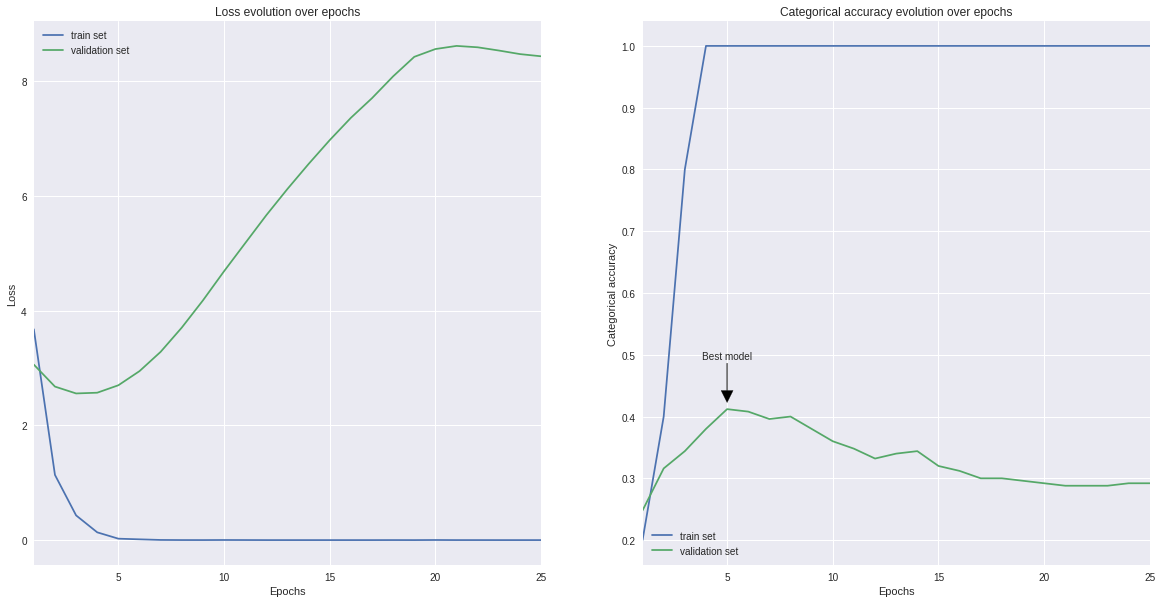

<Figure size 576x396 with 0 Axes>

In [34]:
name = 'Training one short plot history.png'
plot_training_history(history_os, callback_os, savefig=True, name=name)

In [35]:
cat_acc_os_test = model_os.evaluate(test_set_os)[1]

8/8 [==============================] - 1s 97ms/step - loss: 2.4083 - categorical_accuracy: 0.4453


## Results

In [36]:
best_model_index = np.argmax(history['val_categorical_accuracy'])
cat_acc_train = round(history['categorical_accuracy'][best_model_index], 2)
cat_acc_val = round(history['val_categorical_accuracy'][best_model_index], 2)

best_model_os_index = np.argmax(history_os['val_categorical_accuracy'])
cat_acc_os_train = round(history_os['categorical_accuracy'][best_model_index], 2)
cat_acc_os_val = round(history_os['val_categorical_accuracy'][best_model_index], 2)

This part of the project consisted in using a simple CNN to try resolve the task of one shot learning. We built a CNN with 3 convolutional layers, all of them followed by MaxPooling and BatchNorm layers, then a ReLu activation and finally a Dropout layer with probability 0.2. 
The idea was to observe the performance of a relatively simple model on the one short learning task, and comparing it to more advanced techniques, proposed in the other parts.

In [38]:
print('Normal classes metrics:\n')
print('The training accuracy for the normal classes is', cat_acc_train)
print('The validation accuracy for the normal classes is', cat_acc_val)
print('The test accuracy for the normal classes is', round(cat_acc_test, 2))

print('\nOne shot classes metrics:\n')
print('The training accuracy for the normal classes is', cat_acc_os_train)
print('The validation accuracy for the normal classes is', cat_acc_os_val)
print('The test accuracy for the normal classes is', round(cat_acc_os_test, 2))

Normal classes metrics:

The training accuracy for the normal classes is 0.97
The validation accuracy for the normal classes is 0.77
The test accuracy for the normal classes is 0.77

One shot classes metrics:

The training accuracy for the normal classes is 1.0
The validation accuracy for the normal classes is 0.29
The test accuracy for the normal classes is 0.45


In conclusion, even though this simple models performs relatively well on the normal classes, we can see that its performance concerning the one shot learning classes is slightly better than a random classification.